In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-22T05:51:09.190322+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import time
notebookstart= time.time()

In [4]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn import preprocessing

from typing import Tuple

In [5]:
from xgboost import __version__ as xgb_version
from sklearn import __version__ as sklearn_version

print(f'xgb_version: {xgb_version}')
print(f'sklearn_version: {sklearn_version}')

xgb_version: 1.6.1
sklearn_version: 0.24.2


In [6]:
%watermark --iversions

numpy  : 1.20.3
sklearn: 0.24.2
xgboost: 1.6.1
pandas : 0.25.3



## Reproducibility block

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [8]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [9]:
NTRY = 32
NAME = f'{NTRY}_xgb_pca64_sber_bord_nose_iter_2mod'

In [10]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [11]:
df_train  = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)
    
with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [12]:
df_train.shape, df_test.shape, 

((6981, 571), (3000, 569))

In [13]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr', 'interview']
['hour', 'dow', 'day', 'mounth', 'hour_peak', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [14]:
num_cols.extend(['hour', 'mounth', 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 'two_articles',
                 #'spec_event_1',
                ])
#cat_cols.extend(['dow'])

In [15]:
def plot_importance(inp_model, imp_number = 30, imp_type = 'weight'):
    feature_important = inp_model.get_booster().get_score(importance_type=imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(imp_number, columns="score").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [16]:
#def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
def r2(y_pred: np.ndarray, y_true: xgb.DMatrix) -> Tuple[str, float]:
    
    return 'r2', r2_score(y_true.get_label(), y_pred)

## views

In [17]:
#xgb.set_config(verbosity=0)
#xgb_spec = ['day', 'mounth', 'authors_int', 'category_int']

In [18]:
cv_ntrees = 500

xgb_params_views = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
#dtrain_v = xgb.DMatrix(df_train[num_cols], label=df_train[['views']])
#dtrain = xgb.DMatrix(df_train[xgb_spec], label=df_train[['views']])

In [19]:
def get_model(inp_df, inp_params, target):
    
    dtrain = xgb.DMatrix(inp_df[num_cols], label = inp_df[[target]])
    
    scores = xgb.cv(inp_params, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
    
    print(scores[scores['test-rmse-mean'] == scores['test-rmse-mean'].min()][:1].to_string())
    niters = scores['test-rmse-mean'].argmin()
    
    model = XGBRegressor(n_estimators=niters, 
                               #max_depth=7, 
                               #eta=0.1, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

    model.fit(inp_df[num_cols], inp_df[target], 
                    verbose=False
                   )
    
    return model

In [20]:
#if scores_v['test-rmse-mean'].argmin() != scores_v['test-r2-mean'].argmax():
#    raise ValueError('wtf?', scores_v['test-rmse-mean'].argmin(), scores_v['test-r2-mean'].argmax())

In [21]:
%%time
model_views_start = get_model(df_train[df_train.distrib_brdr == 1], xgb_params_views, 'views')

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
9     25820.483955     1578.335306    65149.972564   17986.270784       0.904714      0.006539      0.360492     0.128162
Wall time: 1min 31s


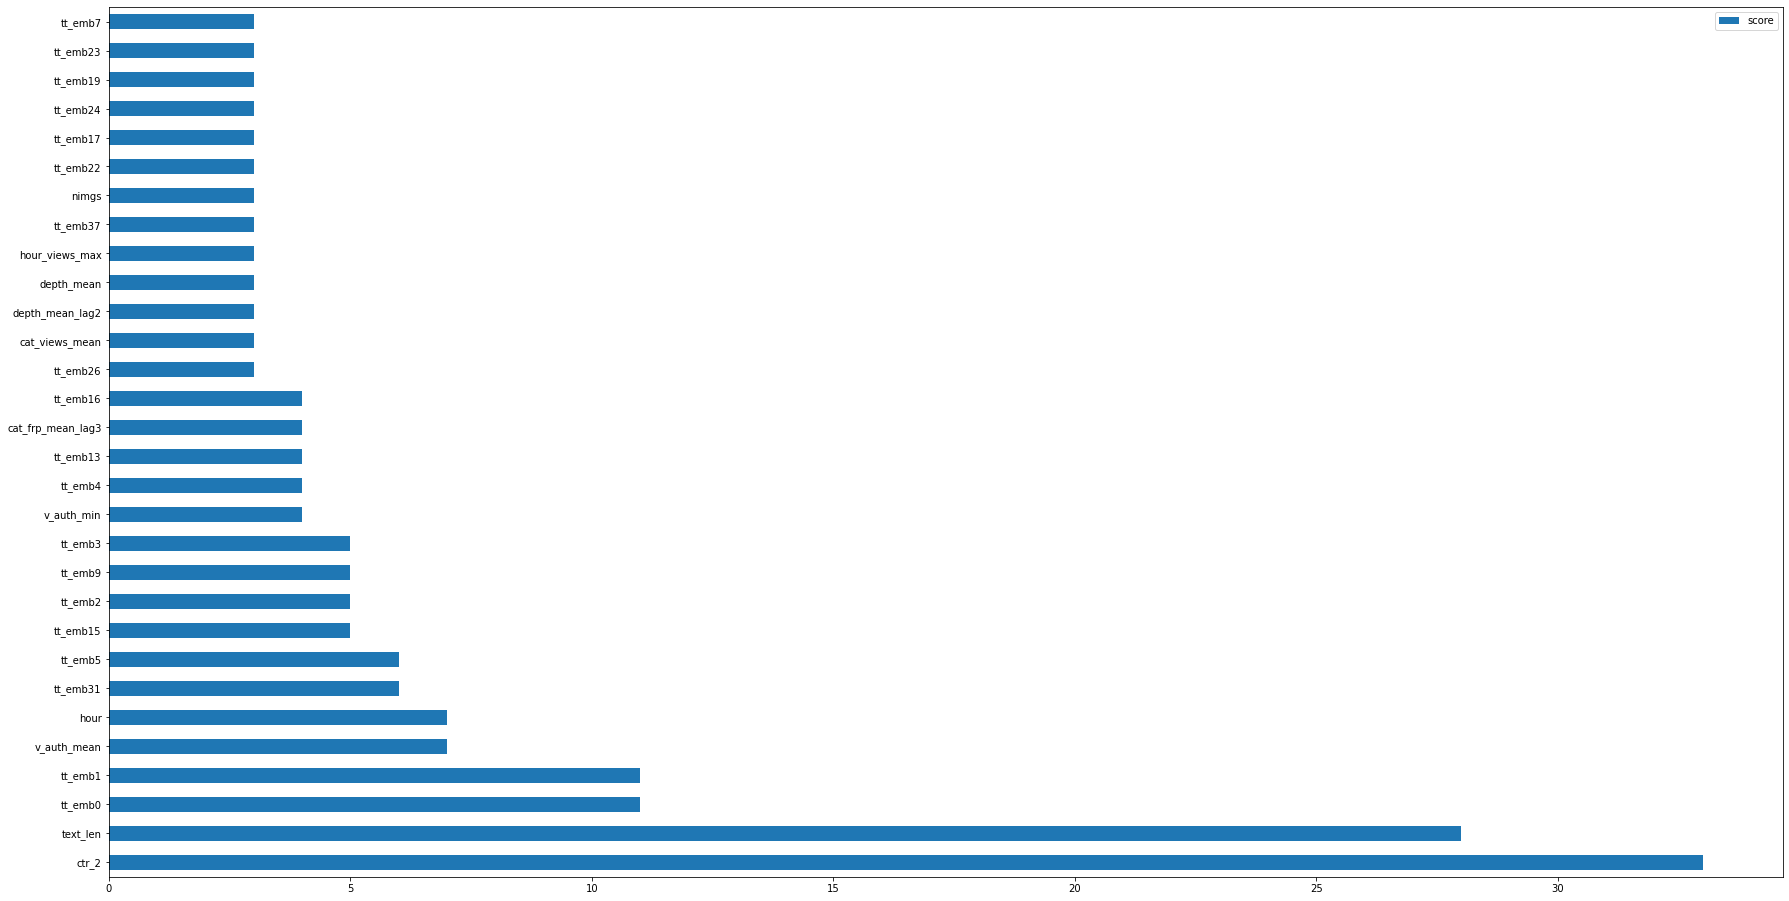

In [22]:
plot_importance(model_views_start, 30, 'weight')

In [23]:
%%time
model_views_end = get_model(df_train[df_train.distrib_brdr == 0], xgb_params_views, 'views')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
29      2669.149669      181.763876     10179.35273     976.284459       0.967556      0.004716      0.526867     0.040686
Wall time: 1min 40s


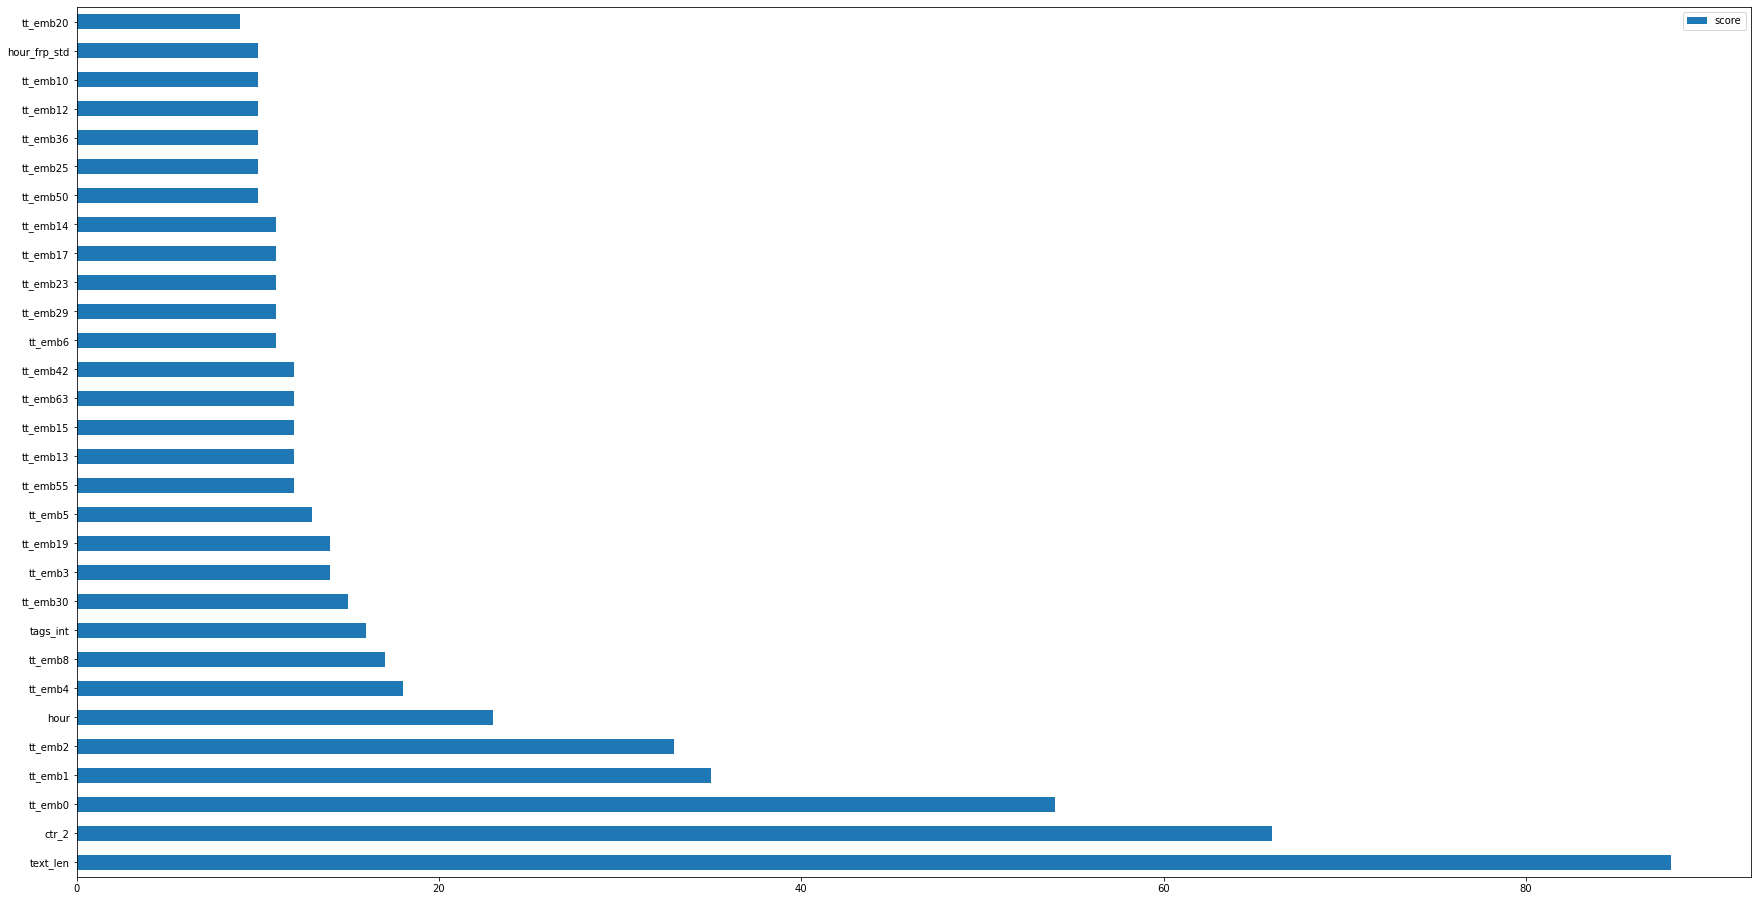

In [24]:
plot_importance(model_views_end, 30, 'weight')

## depth

In [25]:
xgb_params_depth = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
#dtrain_d = xgb.DMatrix(df_train[num_cols], label=df_train[['depth']])

In [26]:
#if scores_d['test-rmse-mean'].argmin() != scores_d['test-r2-mean'].argmax():
#    raise ValueError('wtf?', scores_d['test-rmse-mean'].argmin(), scores_d['test-r2-mean'].argmax())

In [27]:
%%time
model_depth_start = get_model(df_train[df_train.distrib_brdr == 1], xgb_params_depth, 'depth')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
17         0.019964        0.000278        0.036478       0.003494       0.853639      0.009965      0.481458     0.111223
Wall time: 1min 4s


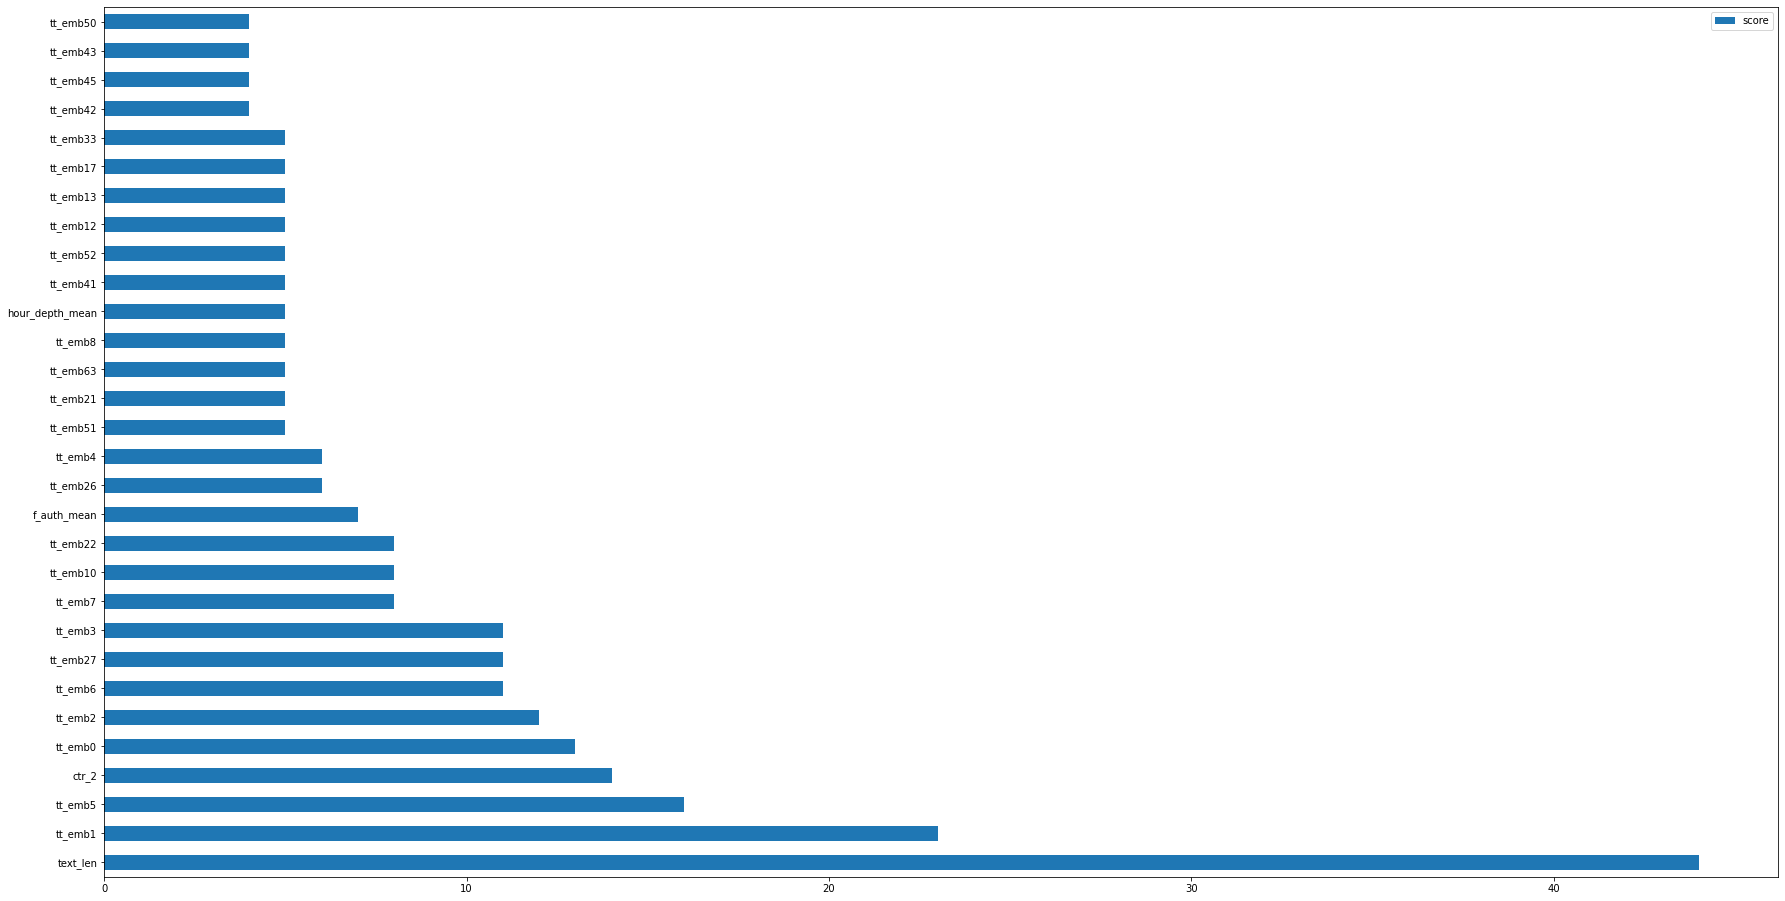

In [28]:
plot_importance(model_depth_start, 30, 'weight')

In [29]:
%%time
model_depth_end = get_model(df_train[df_train.distrib_brdr == 0], xgb_params_depth, 'depth')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
20         0.009772        0.000509        0.015938       0.001936       0.795403      0.011458      0.448899     0.032574
Wall time: 1min 5s


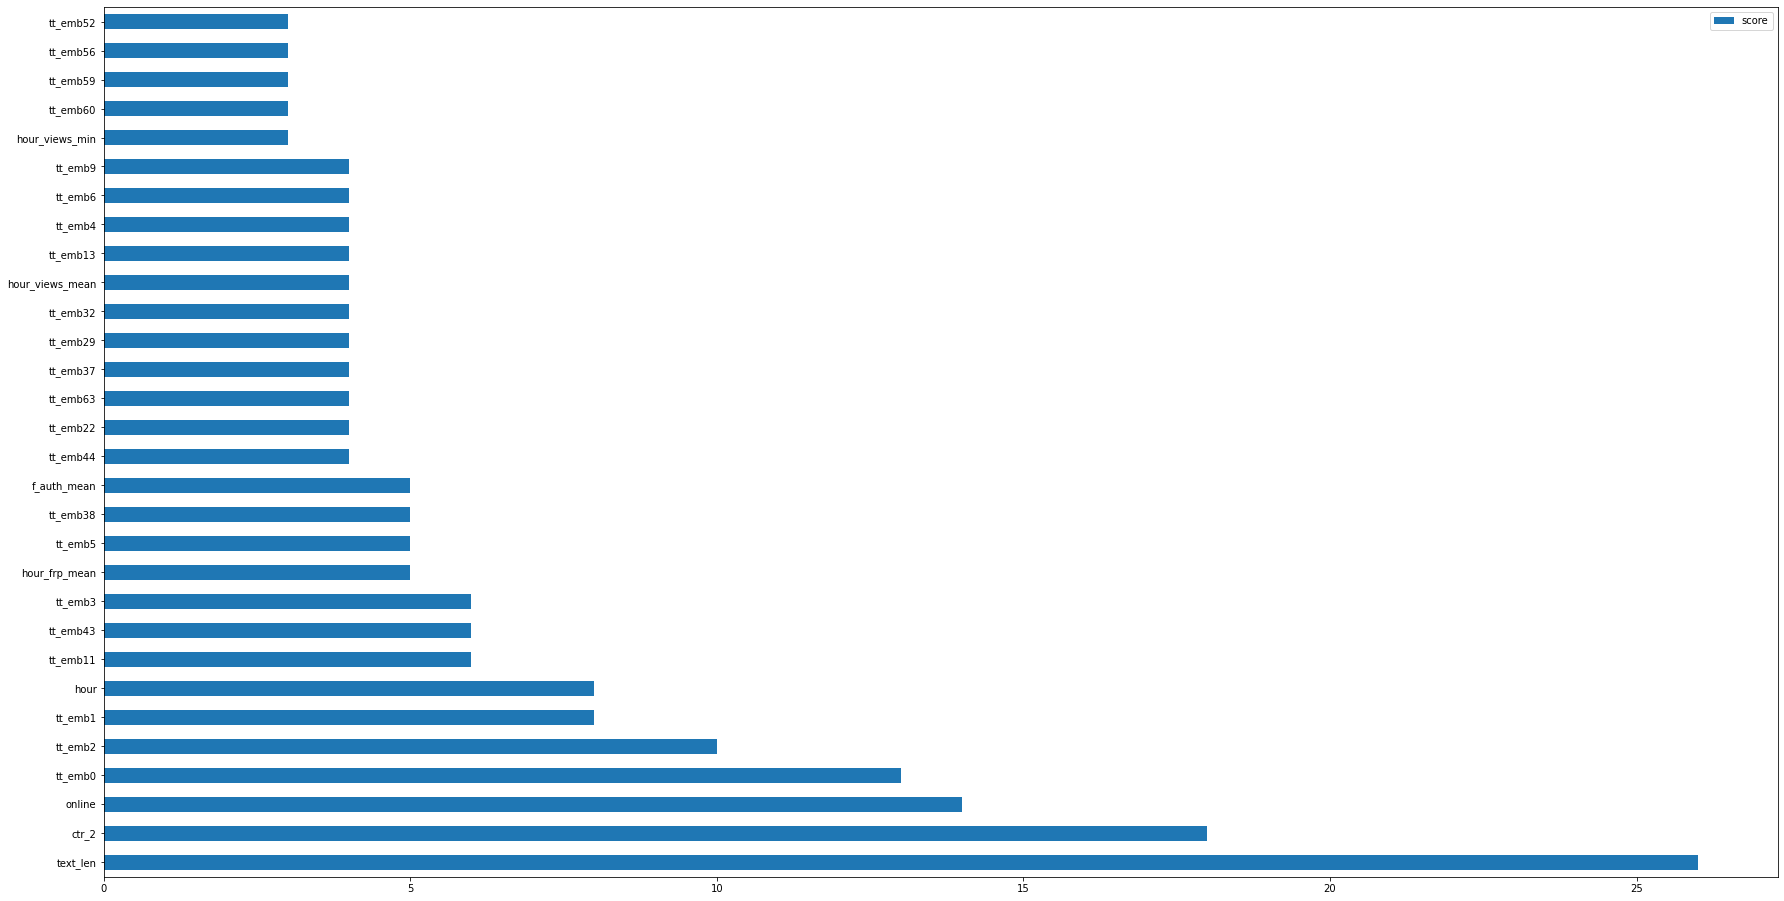

In [30]:
plot_importance(model_depth_end, 30, 'weight')

## full_reads_percent

In [52]:
xgb_params_frp = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
#dtrain_f = xgb.DMatrix(df_train[num_cols], label=df_train[['full_reads_percent']])

In [32]:
#if scores_f['test-rmse-mean'].argmin() != scores_f['test-r2-mean'].argmax():
#    raise ValueError('wtf?', scores_f['test-rmse-mean'].argmin(), scores_f['test-r2-mean'].argmax())

In [33]:
%%time
model_frp_start = get_model(df_train[df_train.distrib_brdr == 1], xgb_params_frp, 'full_reads_percent')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
16         3.793018        0.120115        7.508806        0.10407       0.870213      0.008126      0.490826     0.027774
Wall time: 1min 25s


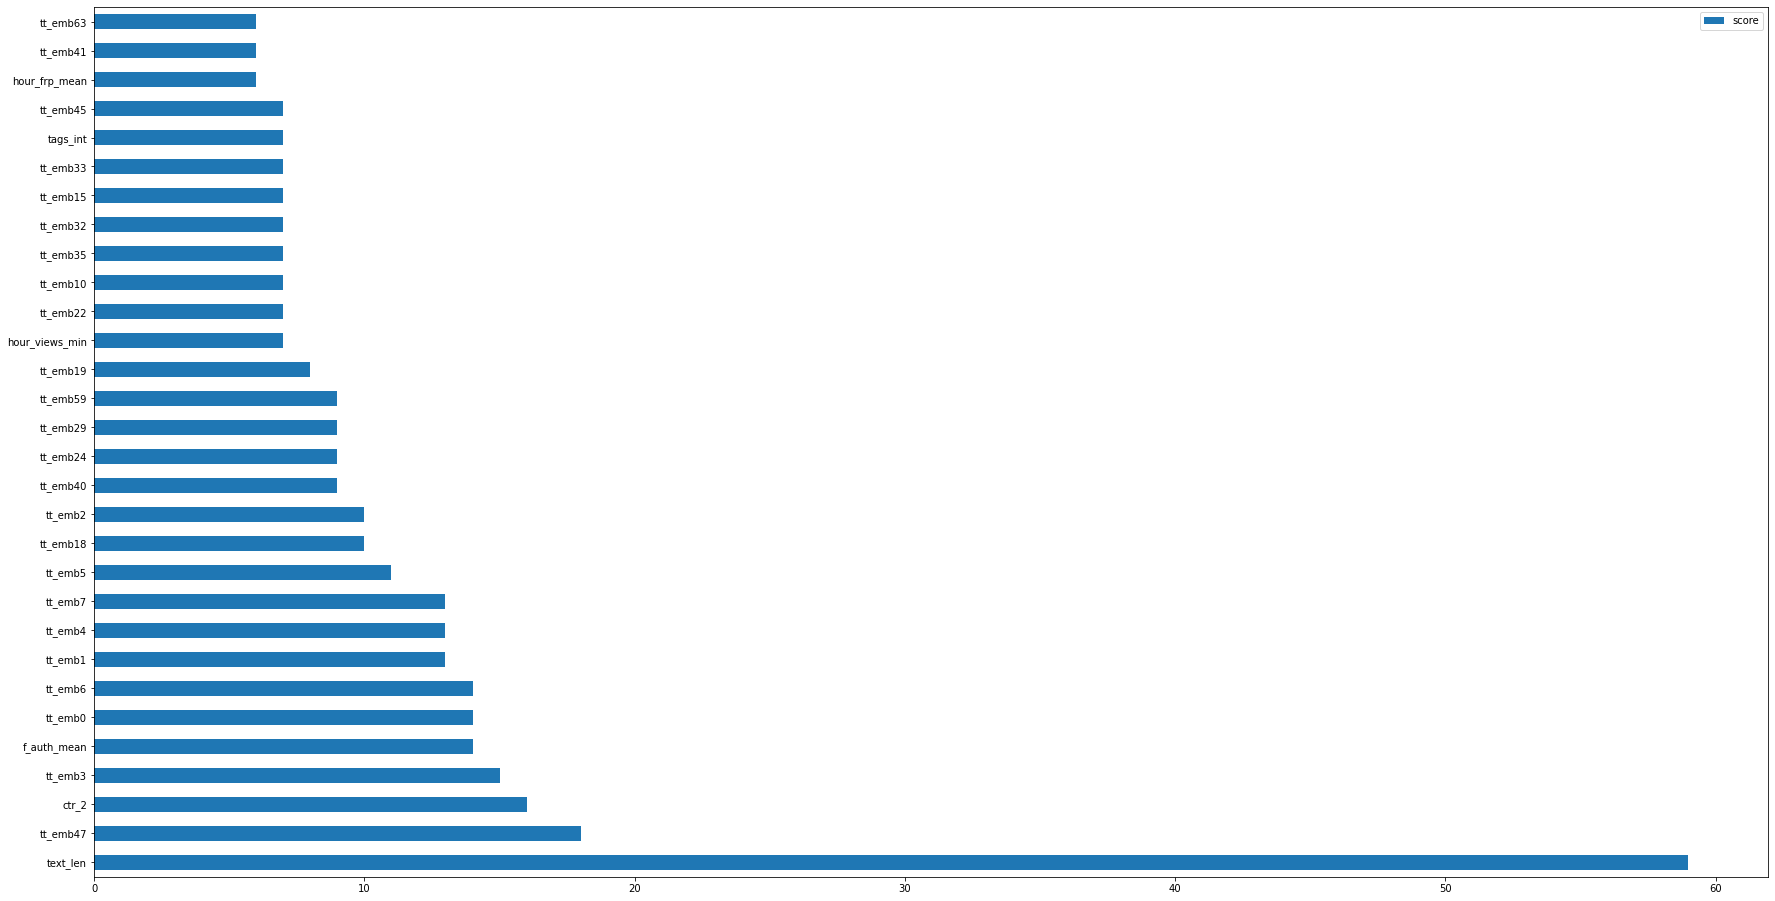

In [34]:
plot_importance(model_frp_start, 30, 'weight')

In [35]:
%%time
model_frp_end = get_model(df_train[df_train.distrib_brdr == 0], xgb_params_frp, 'full_reads_percent')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
19          3.31541        0.044339        6.938423       0.179245       0.882477      0.002308       0.48457     0.020766
Wall time: 1min 42s


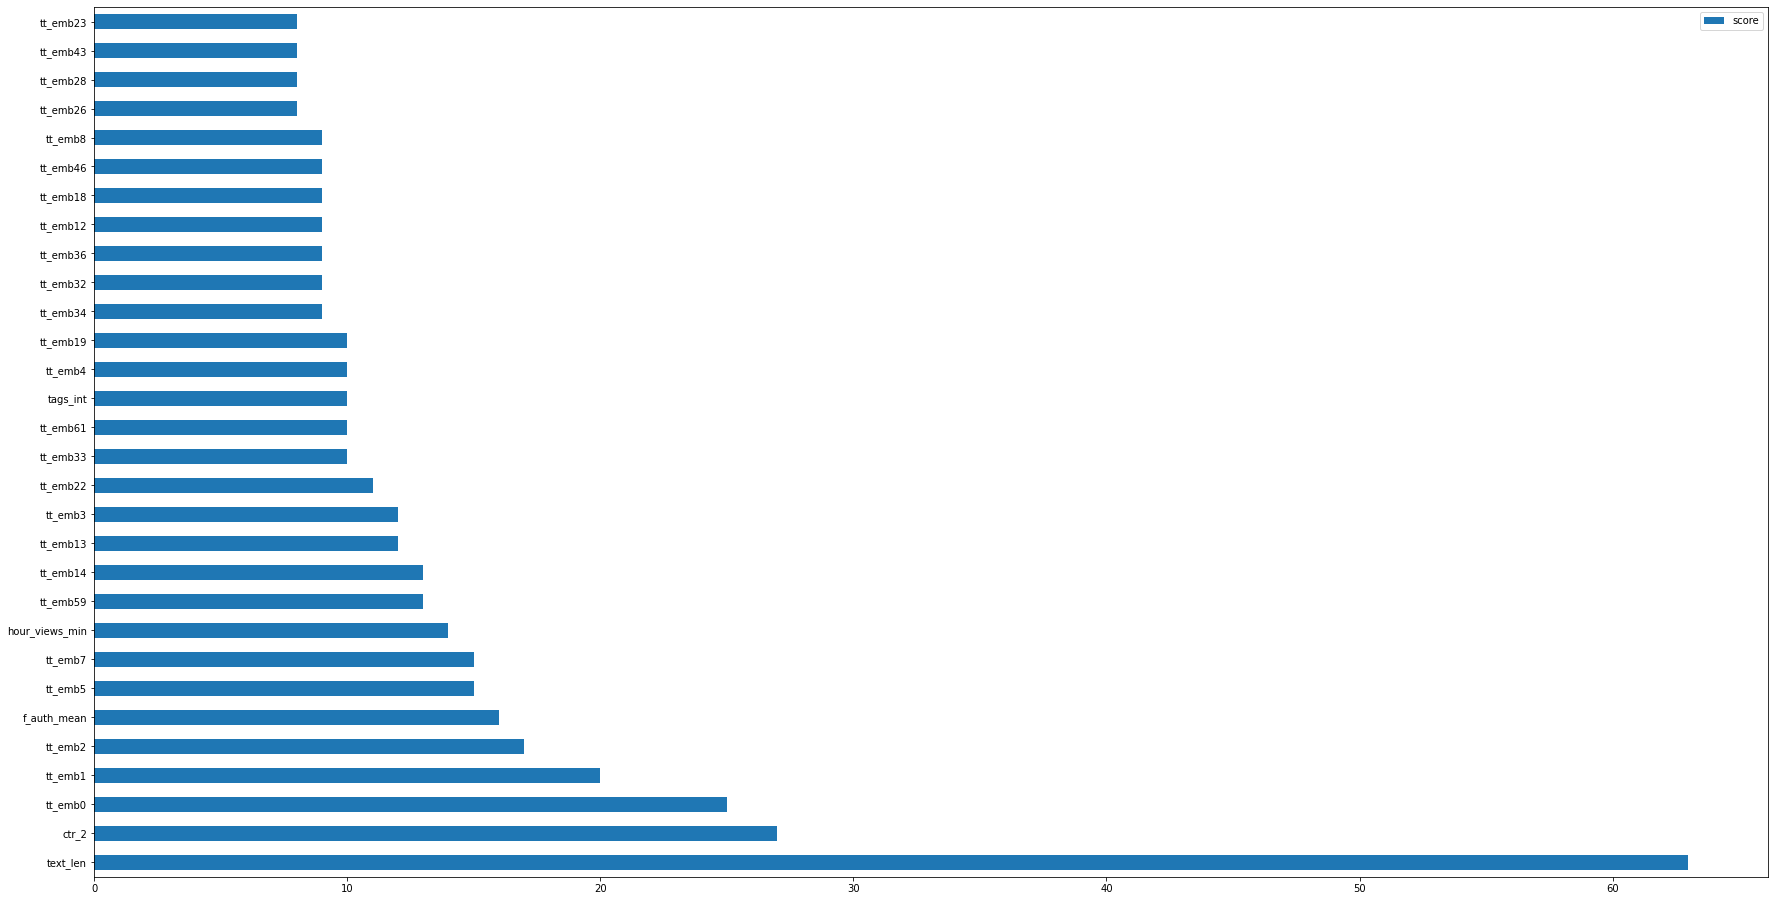

In [36]:
plot_importance(model_frp_end, 30, 'weight')

# Сохраняем предсказания для ансамблей / стекинга

In [37]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [38]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_train[df_train.distrib_brdr == 1][num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_train[df_train.distrib_brdr == 0][num_cols])
print(sum(pred_train.views.isna()), ' Nan in views')

0  Nan in views


In [39]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_train[df_train.distrib_brdr == 1][num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_train[df_train.distrib_brdr == 0][num_cols])
print(sum(pred_train.depth.isna()), ' Nan in depth')

0  Nan in depth


In [40]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_train[df_train.distrib_brdr == 1][num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_train[df_train.distrib_brdr == 0][num_cols])
print(sum(pred_train.full_reads_percent.isna()), ' Nan in full_reads_percent')

0  Nan in full_reads_percent


In [41]:
pred_train.drop(['distrib_brdr'], axis =1, inplace = True)
pred_train.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)

## save models

In [42]:
model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.json'), 
                          )
model_views_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_end.json'), 
                          )

model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.json'), 
                          )
model_depth_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_end.json'), 
                          )

model_frp_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_start.json'), 
                        )
model_frp_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_end.json'), 
                        )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:722: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


## make predict

In [43]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [44]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_test[df_test.distrib_brdr == 1][num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_test[df_test.distrib_brdr == 0][num_cols])
print(sum(subm.views.isna()), ' Nan in views')

0  Nan in views


In [45]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_test[df_test.distrib_brdr == 1][num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_test[df_test.distrib_brdr == 0][num_cols])
print(sum(subm.depth.isna()), ' Nan in depth')

0  Nan in depth


In [46]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_test[df_test.distrib_brdr == 1][num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_test[df_test.distrib_brdr == 0][num_cols])
print(sum(subm.full_reads_percent.isna()), ' Nan in full_reads_percent')

0  Nan in full_reads_percent


In [47]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,167601.078125,1.158460,23.587423
1440,94942.687500,1.181687,24.792372
2645,197067.921875,1.176131,28.034546


In [48]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [49]:
subm.head()

,document_id,distrib_brdr,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,1,16403.242188,1.193659,44.440659
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,0,4924.445801,1.057467,33.509327
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,0,11193.769531,1.063260,31.093771
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,0,6919.605957,1.064121,35.541668
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,1,139940.828125,1.128677,28.509926


In [50]:
subm.drop(['distrib_brdr'], inplace = True, axis = 1)
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)

In [51]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 8.67 Minutes
